In [1]:
import sys, os, re, gzip, json, pickle, shutil, random

import numpy as np

from scipy import stats
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
data_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents'
myspace_mp3s_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_mp3s_path
genre_map_path = '%s/genre_map.pkl' % myspace_mp3s_path
mfcc_path = '%s/audio_features/mfcc' % data_path

#'rock', 'metal', 'dance', 'rap', 'pop', 'jazz', 'experimental', 'world', 'electronic', 'folk', 'punk', 'blues'
binary_genres = ['metal', 'classical']

lab_idx = {g:i for i,g in enumerate(binary_genres)}

In [3]:
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    genre_cts[genre] = len(os.listdir(genre_path))
    
min_recs = min([genre_cts[g] for g in binary_genres])   

for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 13158
metal 8782
alternative 8778
rap 5906
dance 5624
pop 4684
jazz 4552
hip_hop 4526
experimental 3686
other 3544
world 2225
electronic 2127
folk 1804
punk 1729
blues 1472
ambient 1299
reggae 1114
goth 722
acoustic 678
country 533
house 512
classical 486
spiritual 369
oldies 248
progressive 221
funk 142
easy_listening 131
spoken_word 130
bluegrass 48
industrial 44
showtunes 38
disco 23


In [4]:
with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
    metadata = json.load(fz)

with open(genre_map_path, 'rb') as f:
    genre_map = pickle.load(f)
    
#example metadata
kys = list(metadata.keys())
ky=kys[0]
ky, metadata[ky]

('46/std_1f69563352d19cb0132334cd0d3adeaf.mp3',
 {'song_name': 'big_yellow_moon',
  'artist_name': 'bill_nelson',
  'mp3_zipname': '46',
  'mp3_filename': 'std_1f69563352d19cb0132334cd0d3adeaf.mp3',
  'genres': ['rock', 'electronica', 'alternative']})

In [5]:
def get_mfcc_lengths(mfcc_path, genres, max_recs):
    lens=[]
    
    for genre in binary_genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            mfcc = np.load(fp)
            lens.append(mfcc.shape[1])
            ct+=1
            if ct>=min_recs:
                break
                
    l = np.array(lens)
    
    return l

Mean mfcc length: 9853.0833, std: 4784.7813


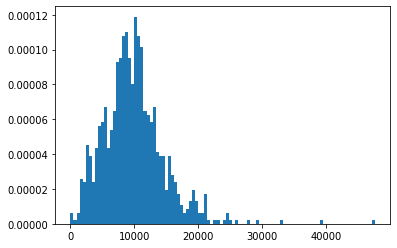

In [6]:
l = get_mfcc_lengths(mfcc_path, binary_genres, min_recs)

print('Mean mfcc length: %.4f, std: %.4f' % (l.mean(), l.std())) #9792.02380952381, 4837.91379828136

plt.hist(l, bins=100, density=True)
plt.show()

### Try different ways of dealing with the varying mfcc lengths

In [7]:
mfcc = np.load('%s/acoustic/msp_1_std_1b7ee19baed6ae4ea7332a60db0bcb4f.npy' % mfcc_path)

In [8]:
np.vstack([mfcc.mean(axis=1), mfcc.std(axis=1), stats.kurtosis(mfcc, axis=1), stats.skew(mfcc, axis=1)])

array([[-2.8108591e+02,  1.2224055e+02,  2.8064362e+01,  3.1553217e+01,
         1.5940080e+01,  1.3792233e+01,  4.4775543e+00,  5.4401940e-01,
        -8.0222225e+00, -9.0548048e+00, -7.3031354e+00, -8.1062689e+00,
        -9.4938993e+00, -7.5461569e+00, -9.5483360e+00, -1.1156130e+01,
        -1.2253296e+01, -7.0494881e+00, -7.5009913e+00, -6.9211936e+00],
       [ 8.6951828e+01,  2.9867422e+01,  1.9666704e+01,  1.4971158e+01,
         1.1757245e+01,  8.2338200e+00,  8.2472515e+00,  7.4393983e+00,
         7.9877319e+00,  1.0237029e+01,  8.3215666e+00,  7.6278958e+00,
         8.1165676e+00,  7.5231209e+00,  7.4042001e+00,  6.7408314e+00,
         6.5452747e+00,  6.6313405e+00,  7.7863317e+00,  7.5268083e+00],
       [-2.0438838e-01,  1.9405127e+00,  8.4137917e-01,  7.3870349e-01,
         7.7184796e-01,  5.1357436e-01,  1.5301127e+00,  9.4353080e-01,
         3.4467864e-01,  2.7901173e-02, -4.7985554e-02, -1.4419651e-01,
         7.4904442e-02, -1.5321231e-01,  2.5043797e-01,  5.465

In [9]:
def shuffle_data(x, y):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    return (x-x.mean())/x.std()


def get_col_stats(mfcc_path, genres, lab_idx, max_recs):
    mfccs = []
    y=[]
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            
            mfcc = np.load(fp)
            mfccs.append(np.hstack([mfcc.mean(axis=1), 
                                    mfcc.std(axis=1), 
                                    stats.kurtosis(mfcc, axis=1), 
                                    stats.skew(mfcc, axis=1)]))
            
            y.append(lab_idx[genre])
            
            ct+=1
            if ct>=max_recs:
                break
                
    x = np.array(mfccs)
    x = normalize_data(x)
    
    y = np.array(y)
    
    return shuffle_data(x, y)

                
def truncate_cols(mfcc_path, genres, lab_idx, col_len, max_recs):
    mfccs = []
    y=[]
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            
            mfcc = np.load(fp)[:,:col_len]
            mfccs.append(np.pad(mfcc, ((0,0),(0,col_len-mfcc.shape[1])), 'constant'))
            
            y.append(lab_idx[genre])
            
            ct+=1
            if ct>=max_recs:
                break
                
    x = np.array(mfccs)
    y = np.array(y)
                
    return shuffle_data(x, y)


def svd_reduce(x, n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    x = svd.fit_transform(x.reshape(x.shape[0], -1))
    print(x.shape, svd.explained_variance_ratio_.sum())
    
    return x

In [10]:
x, y = get_col_stats(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape

((972, 80), (972,))

In [11]:
num_test = x.shape[0]//5
x_train, x_test, y_train, y_test = x[num_test:], x[:num_test], y[num_test:], y[:num_test]

### Different models

#### Col_stats, Logistic Regression

In [12]:
from sklearn.metrics import classification_report

In [13]:
log_reg = LogisticRegression(C=1.0, max_iter=1000)

clf = log_reg.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.91

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        86
           1       0.96      0.90      0.93       108

    accuracy                           0.92       194
   macro avg       0.92      0.93      0.92       194
weighted avg       0.93      0.92      0.92       194



#### Col_stats, LinearSVM

In [14]:
lin_svm = LinearSVC(C=1.0, loss='hinge', max_iter=10000)

clf = lin_svm.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.92

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        86
           1       0.96      0.89      0.92       108

    accuracy                           0.92       194
   macro avg       0.92      0.92      0.92       194
weighted avg       0.92      0.92      0.92       194



C:\Users\tianyi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Col_stats, SVM

In [15]:
svm = SVC(C=1.0, kernel='sigmoid', gamma='scale')

clf = svm.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

#poly, degree 2: 0.89
#poly, degree 3: 0.88
#rbf: 0.9
#sigmoid: 0.83

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        86
           1       0.79      0.79      0.79       108

    accuracy                           0.77       194
   macro avg       0.77      0.77      0.77       194
weighted avg       0.77      0.77      0.77       194



#### MLP

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(10), solver='adam', max_iter=2500)

clf = mlp.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

#adam
#hid 3 : 0.91
#hid 5 : 0.92
#hid 10 : 0.92
#hid 20 : 0.91
#hid 50 : 0.91
#hid 100 : 0.91
#hid 200 : 0.91
#hid 500 : 0.90
#hid 5,5 : 0.88
#hid 10,5 : 0.89
#hid 20,10 : 0.9
#hid 100,50 : 0.89

#sgd always did a bit worse than adam, lbfgs did even worse

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       101
           1       0.90      0.88      0.89        93

    accuracy                           0.90       194
   macro avg       0.90      0.90      0.90       194
weighted avg       0.90      0.90      0.90       194



####  = QuadraticDiscriminantAnalysis()

In [20]:
qda = QuadraticDiscriminantAnalysis()
    
clf = qda.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.87

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       101
           1       0.85      0.92      0.89        93

    accuracy                           0.89       194
   macro avg       0.89      0.89      0.89       194
weighted avg       0.89      0.89      0.89       194



#### Custom network

In [21]:
class MusicClassifier(nn.Module):
    def __init__(self, num_in, num_out):
        super(MusicClassifier, self).__init__()
        self.layer_1 = nn.Linear(num_in, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_out = nn.Linear(256, num_out)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [22]:
lr = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MusicClassifier(x_train.shape[1], 1)
model.to(device)
model.train()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

cpu


In [23]:
def train_model(x, y, model, optimizer, criterion, batch_size, epochs, device):
    x_batches = [x[i*batch_size:(i+1)*batch_size] for i in range((x.shape[0]//batch_size) + 1)]
    y_batches = [y[i*batch_size:(i+1)*batch_size] for i in range((x.shape[0]//batch_size) + 1)]
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        
        idx = list(range(len(x_batches)))
        random.shuffle(idx)
        x_batches = [x_batches[i] for i in idx]
        y_batches = [y_batches[i] for i in idx]
        
        for x_batch, y_batch in zip(x_batches, y_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        print('Epoch %d\tLoss: %.8f\tAcc: %.8f' % (epoch, epoch_loss/len(x_batches), epoch_acc/len(x_batches)))
        
    return model
        
        
def binary_acc(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred))

    cor = (y_pred == y_test).sum().float()
    acc = cor/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def test(x_test, y_test, model):
    model.eval()
    y_preds = []

    with torch.no_grad():
        y_pred = model(x_test)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred).cpu().numpy()
        y_preds.append(y_pred)

    y_preds = [a.squeeze().tolist() for a in y_preds]
    y_preds = [int(y) for y in y_preds[0]]
    
    print(classification_report(y_test.tolist(), y_preds))

In [24]:
batch_size = 128
epochs = 50
model = train_model(torch.from_numpy(x), torch.from_numpy(y).float(), 
            model, optimizer, criterion, batch_size, epochs, device)

Epoch 1	Loss: 0.35129818	Acc: 84.00000000
Epoch 2	Loss: 0.23824837	Acc: 91.62500000
Epoch 3	Loss: 0.20600965	Acc: 91.75000000
Epoch 4	Loss: 0.18998510	Acc: 92.25000000
Epoch 5	Loss: 0.17556997	Acc: 92.62500000
Epoch 6	Loss: 0.16100627	Acc: 94.00000000
Epoch 7	Loss: 0.15209224	Acc: 94.25000000
Epoch 8	Loss: 0.14115577	Acc: 94.37500000
Epoch 9	Loss: 0.12593920	Acc: 95.00000000
Epoch 10	Loss: 0.11604617	Acc: 95.62500000
Epoch 11	Loss: 0.10517112	Acc: 96.12500000
Epoch 12	Loss: 0.09229265	Acc: 96.75000000
Epoch 13	Loss: 0.08453739	Acc: 97.12500000
Epoch 14	Loss: 0.07822492	Acc: 97.37500000
Epoch 15	Loss: 0.06613373	Acc: 98.00000000
Epoch 16	Loss: 0.05647346	Acc: 98.12500000
Epoch 17	Loss: 0.04368902	Acc: 99.12500000
Epoch 18	Loss: 0.03834940	Acc: 99.12500000
Epoch 19	Loss: 0.03124489	Acc: 99.50000000
Epoch 20	Loss: 0.02834616	Acc: 99.25000000
Epoch 21	Loss: 0.02659929	Acc: 99.37500000
Epoch 22	Loss: 0.02364095	Acc: 99.50000000
Epoch 23	Loss: 0.01670141	Acc: 100.00000000
Epoch 24	Loss: 0.01

In [25]:
test(torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).float().to(device), model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       101
         1.0       1.00      1.00      1.00        93

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194



#### CNN for padded raw mfccs